# Katzen gegen Hunde -- Tricks of the Trade

Wie wir im vorangegangenen Notebook gesehen haben, lassen sich durch die blosse Anwendung eines vortrainierten VGG16 bereits Vorhersagen mit verblueffend hoher Genauigkeit erzielen.

Die Vorhersagegenauigkeit kann durch drei einfache Tricks weiter verbessert werden: 
1. **Data Augmentation**
2. **Ensembling**
3. **Semi-Supervised Learning**

## Data Augmentation

In [2]:
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras.optimizers import Adam
from tensorflow.contrib.keras.python.keras.layers import Dense, Flatten
from tensorflow.contrib.keras.python.keras.models import Sequential, Model

import sys
import numpy as np
sys.path.insert(0, '../scripts')
import nn_helper
from nn_helper import show_array, show_array_list
from matplotlib import pyplot as plt
%matplotlib inline

Wir haben gesehen, dass neuronale Netze die feinen Unterschiede zwischen Katzen und Hunden lernen koennen. Um aus den Bilddaten allgemeine Features extrahieren zu koennen brauchen sie aber viele viele Beispiele.

In der Praxis ist das Hinzufuegen neuer Daten oft teuer oder nicht durchfuehrbar. In diesen Faellen versuchen wir synthetisch neue Bilder aus dem vorhandenen Datensatz zu erzeugen. Diesen Ansatz bezeichnen wir als __data augmentation__.

In [5]:
#############################################
############FILE PATHS
#############################################
ROOT = '../../deepLearning/data/processed/cats_vs_dogs'
FEATURE_PATH = '../../deepLearning/features/cats_vs_dogs'

SEED = 42

Keras stellt einen ImageDataGenerator  bereit-- ein nuetzliches Werkzeug um ein gegebene Bilder zu verzerren.

In [6]:
data_gen = ImageDataGenerator()

data_gen_aug = ImageDataGenerator(rotation_range=40, width_shift_range=0.15, zoom_range=0.25,
                                      channel_shift_range=10, height_shift_range=0.15, shear_range=0.15,
                   horizontal_flip=True)

Als naechstes laden wir Bilder aus unserem trainingsdatensatz und verzerren diese.

In [7]:
np.random.seed(SEED)
train_gen = data_gen.flow_from_directory('{}/train'.format(ROOT), shuffle = True)
_=next(train_gen)

np.random.seed(SEED)
train_gen_aug = data_gen_aug.flow_from_directory('{}/train'.format(ROOT), shuffle = True)
_=next(train_gen_aug)


Found 24000 images belonging to 2 classes.
Found 24000 images belonging to 2 classes.


Now, we can compare the original images with the augmented ones.

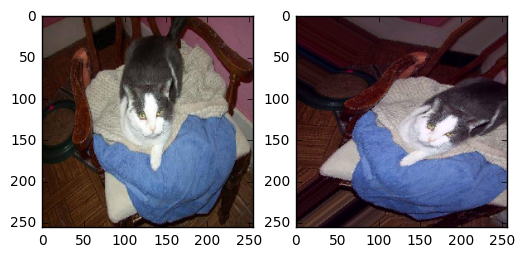

In [15]:
a = next(train_gen)
b = next(train_gen_aug)

show_array_list([a[0][1,:,:,:], b[0][1,:,:,:]])

## Ensembling

Deep Learning-Netze haengen typischerweise von Millionen von Gewichte ab. Diese werden zunaechst zufaellig initialisiert und dann mittels Gradient-Descent Schritt fuer Schritt angepasst.

Je nach Initialisierung koennen sich die Parameter in ganz unterschiedliche Richtungen Entwicklungen, sodass in der Praxis die Vorhersagekraft oft merkbar vom Zufalls-See abhaengt.

Diese Eigenschaft kann man sich durch die Bildung von **Ensembles** zu Nutze machen: Durch Mittelung der Vorhersagen verschiedener Initialisierungen gelangt man zu einem besseren Bias-Variance Tradeoff. 

Wir betrachten das Beispiel zur Vorhersage aus VGG-Features aus dem vorangegangenen Notebook

In [158]:
vgg_conv_features =  [np.load('{}/vgg_conv_features_{}.npy'.format(FEATURE_PATH, tv)) 
                      for tv in ['train', 'valid']]

labels = [np.load('{}/vgg_features_names_{}.npy'.format(FEATURE_PATH, tv))
       for tv in ['train', 'valid']]

Wir definieren unser bevorzugtes Modell

In [148]:
def create_model():
    return Sequential([])

Wir fitten das Modell nur auf einem Teil der Daten.

In [339]:
def model_generator(lr, n_sample, epochs, seed = None):
    """Return fitted models
    
    #Arguments:
     lr: learning rate
     n_sample: size of sample
     epochs: number of epochs for fitting
     """
    while(True):
        model = create_model()
        model.compile()

        if(seed):
            np.random.seed(SEED)

        subsample = np.random.choice(range(len(labels[0])), n_sample, replace = False)

        model.fit(None, None, epochs = epochs, verbose = 2)
        yield model

Nun erzeugen wir ein Ensemble aus verschiedenen Initialisierungen.

In [273]:
def create_ensemble(n_ens, model_generator):
    """Create ensemble of models
    
    #Arguments
     n_ens: number of models in ensembling
     model_generator: generator for creating models
     
    #Result
     list containing ensemble of fitted models
    """
    models = []
    return models

In [340]:
N_ENS = 5
N_SAMPLE = 100
LR = 1e-4
EPOCHS = 10

models = create_ensemble(N_ENS, model_generator(LR, N_SAMPLE, EPOCHS, SEED))

Train on 100 samples, validate on 1000 samples
Epoch 1/10
1s - loss: 3.5505 - acc: 0.6000 - val_loss: 1.9970 - val_acc: 0.7300
Epoch 2/10
0s - loss: 0.8235 - acc: 0.9100 - val_loss: 1.8100 - val_acc: 0.7890
Epoch 3/10
0s - loss: 0.2790 - acc: 0.9500 - val_loss: 2.1074 - val_acc: 0.7660
Epoch 4/10
0s - loss: 0.1641 - acc: 0.9900 - val_loss: 2.1850 - val_acc: 0.7620
Epoch 5/10
0s - loss: 0.1613 - acc: 0.9900 - val_loss: 2.1680 - val_acc: 0.7680
Epoch 6/10
0s - loss: 0.1612 - acc: 0.9900 - val_loss: 2.1510 - val_acc: 0.7710
Epoch 7/10
0s - loss: 0.1612 - acc: 0.9900 - val_loss: 2.1333 - val_acc: 0.7750
Epoch 8/10
0s - loss: 0.1612 - acc: 0.9900 - val_loss: 2.1206 - val_acc: 0.7770
Epoch 9/10
0s - loss: 0.1612 - acc: 0.9900 - val_loss: 2.1108 - val_acc: 0.7780
Epoch 10/10
0s - loss: 0.1612 - acc: 0.9900 - val_loss: 2.1014 - val_acc: 0.7780
Train on 100 samples, validate on 1000 samples
Epoch 1/10
1s - loss: 4.6181 - acc: 0.5500 - val_loss: 4.3542 - val_acc: 0.6090
Epoch 2/10
0s - loss: 1.6

Betrachten wir nun die Vorhersagen der einzelnen Modelle.

In [344]:
predictions = [None for model in models]

from sklearn.metrics import log_loss
[log_loss(None, None, 1e-3) for prediction in predictions]

[1.229417909257114,
 1.4005361237531762,
 1.3993384711708641,
 0.86650557343952828,
 0.88824918870651159]

Und nun zum Vergleich die Vorhersagen die Verlustfunktion des ensembles.

In [345]:
averaged_preds = np.mean()


log_loss(None, None, 1e-3)

0.37266839612694458

Jetzt betrachten wir den Klassifizierungsfehler

In [346]:
class_preds = [None for model in models]


[None for class_pred in class_preds]


[0.77800000000000002,
 0.77600000000000002,
 0.77700000000000002,
 0.85099999999999998,
 0.84999999999999998]

Und wieder fuer die Vorhersagefunktion

In [347]:
maj_preds = np.apply_along_axis(None, axis = 0, arr = np.vstack(class_preds))

np.mean()

0.84299999999999997

## Semi-supervised Learning

Bei einem frueheren sehr vereinfachten Modell, konnten wir bereits mit einer geringen Datenmenge das Optimum aus dem Modell herausholen. In dem komplexeren und genaueren Modell oben ist dies nicht ohne weiteres moeglich.

In der Praxis ist dies haeufig eines der groessten Hindernisse beim Anwenden von Deep-Learning fuer das **Supervised Learning**. Grosse gelabelte Datenmengen sind teuer.

Dagegen sind ungelabelte Daten oft in grosser Quantitaet frei verfuegbar. Diese Daten koennen fuer Probleme aus dem Bereich des **Unsupervised Learnings** genutzt werden.

Die Idee des **Semi-supervised Learning** ist die Masse der vorhandenen ungelabelten Datenmengen zur Unterstuetzung des Supervised Learnings zu verwenden.

### 1. Beispiel Cats vs dogs

Wir veranschaulichen dies an obigem Beispiel.

In [367]:
model = next(model_generator(LR, N_SAMPLE, 20, SEED))

Train on 100 samples, validate on 1000 samples
Epoch 1/20
1s - loss: 4.5081 - acc: 0.5700 - val_loss: 3.0221 - val_acc: 0.7010
Epoch 2/20
0s - loss: 1.5536 - acc: 0.8800 - val_loss: 2.6123 - val_acc: 0.7330
Epoch 3/20
0s - loss: 0.8627 - acc: 0.9200 - val_loss: 2.5642 - val_acc: 0.7430
Epoch 4/20
0s - loss: 0.3197 - acc: 0.9800 - val_loss: 2.2971 - val_acc: 0.7770
Epoch 5/20
0s - loss: 0.3119 - acc: 0.9800 - val_loss: 2.0035 - val_acc: 0.8030
Epoch 6/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.8319 - val_acc: 0.8180
Epoch 7/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.7354 - val_acc: 0.8300
Epoch 8/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.6763 - val_acc: 0.8380
Epoch 9/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.6421 - val_acc: 0.8400
Epoch 10/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.6180 - val_acc: 0.8420
Epoch 11/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.6024 - val_acc: 0.8430
Epoch 12/20
0s - loss: 0.1594 - acc: 0.9900 - val_loss: 1.5919 - val_ac

Mit dem nun trainierten Modell bilden wir vorhersagen auf einem viel groesseren Datenset

In [368]:
N_UNSUP = int(1e4)
pseudo_labels = model.predict()

Nun reichern wir das bisherige Modell mit den so erzeugten *Pseudo-Labels* an.

In [369]:
model.fit(None, pseudo_labels, epochs = 1,)

Train on 24000 samples, validate on 1000 samples
Epoch 1/1
24000/24000 [==============================] - 17s - loss: 0.3180 - acc: 0.4232 - val_loss: 0.5897 - val_acc: 0.8620

### 2. Beispiel MNIST


Als weiteres Beispiel um die Maechtigkeit des semi-supervised learnings zu veranschaulichen betrachten wir den ``MNIST``-Datensatz, den wir bereits in unserem Beispiel zu Convolutions untersucht haben. Es geht hier darum Ziffern die auf `28 x 28` dargestellt sind zu erkennen.

Fuer MNIST gibt es ein sehr schoenes [Tutorial](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) in Keras dessen wir uns hier bedienen. Zunaechst laden wir einige Bibliothekne.

In [12]:
import keras
import tensorflow
import numpy as np
from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense,  Flatten
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.contrib.keras.python.keras.optimizers import Adadelta
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils import to_categorical

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

Nun laden wir die Daten und fuehren Preprocessing durch

In [7]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test =  to_categorical(y_test, num_classes)

Als naechstes definieren wir das CNN das wir zur MNIST-Klassifizierung verwenden.

In [9]:
def create_cnn():
    return Sequential([
        Conv2D(, activation='relu', input_shape=input_shape),
        Conv2D(, activation='relu'), 
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(, activation='relu'), 
        Dense(num_classes, activation='softmax')
        ])
    

In [10]:
create_cnn()

Nun kompilieren wir das Modell und fitten es an die Daten

In [14]:
model = create_cnn()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer= Adadelta(), metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs = 1, 
          validation_data=(x_test, y_test))

Jetzt ersetzen wir die Haelfte der Trainingslabels durch ein komplett zufaelliges Label und trainieren das DNN erneut.

In [21]:
flip_set = None
y_train[flip_set, :] = None

In [22]:
model = create_cnn()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs = 1, 
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 232s - loss: 2.1750 - acc: 0.2904 - val_loss: 1.3640 - val_acc: 0.9407